In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
sys.path.insert(1, oj(sys.path[0], '..', 'vision_fit'))  # insert parent path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import math
# plt.style.use('dark_background')
from mog_fit import data
from collections import OrderedDict
from sklearn import preprocessing

import torch
from torch.autograd import Variable
from mog_analyze import viz
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

from vision_fit import data
import viz_weights
from process_results import process_results

%matplotlib inline
%load_ext autoreload
%autoreload 2

import style
cb = '#008fd5'
cr = '#fc4f30'

In [2]:
style.set_style()

# load results from a directory

In [19]:
# depending on how much is saved, this may take a while
# out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/transfer/mnist_permute'
out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/transfer/mnist_permute_change_freq'
# out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/transfer/mnist_rotate'

fnames = sorted([fname for fname in os.listdir(out_dir) \
                 if not fname.startswith('weights') \
                 and not fname.startswith('idx')])
#                  if not 'mnist' in fname and 
#                  'numlays=4' in fname and 
#                  'batchsize=100' in fname and not 'batchsize=1000' in fname])
#                   and 
#                  'numlays=4' in fname]) # and 
#                  'batchsize=100' in fname and 
#                  not 'batchsize=1000' in fname])
# weights_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in tqdm(fnames) 
#                 if fname.startswith('weights')]
# results_weights = pd.concat(weights_list, axis=1).T.infer_objects()

results_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in tqdm(fnames) 
                if not fname.startswith('weights') and not fname.startswith('idx')]
results = pd.concat(results_list, axis=1).T.infer_objects()

100%|██████████| 90/90 [00:00<00:00, 268.62it/s]


**add cols**

In [20]:
# adds these vec keys: fc0_fro, fc1_fro, fc0_stab_rank, fc1_stab_rank, act0_stab_rank, act1_stab_rank, corr0, corr1
# adds these scalar keys: max_train_acc, max_test_acc, _final of all the above
its, ts, results = process_results(results)
# print(results[['max_train_acc', 'optimizer']])

# track things over time

In [21]:
from random import randint
cs = []

for i in range(25):
    cs.append('#%06X' % randint(0, 0xFFFFFF))
cs = sorted(cs)
cs = {False: 'red', True: 'blue'}

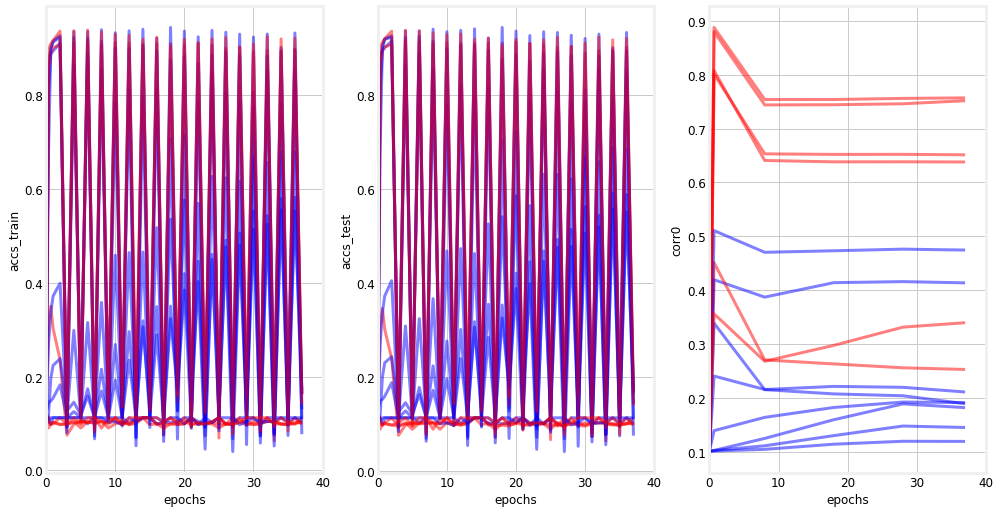

In [29]:
r = results
r = r[r.change_freq == 2]
# r = r[r.hidden_size == 32]

R, C = 1, 3
plt.figure(figsize=(15, 8))
xlim = 40

vals = ['accs_train', 'accs_test', 'corr0'] #, 'corr0', 'corr1', 'fc0_fro', 'fc1_fro', 'fc0_stab_rank', 'fc1_stab_rank', 'act0_stab_rank', 'act1_stab_rank']

# hue = 'normalize_features'
hue = 'optimizer'
# cs = {0: cb, 1: cr, 2: 'black', 3: 'green'}
# well-behaved
for _, row in r.iterrows():

    for i, val in enumerate(vals):
        plt.subplot(R, C, i+1)
        try:
            plt.plot(ts, row[val], color=cs[row[hue]=='sgd'], alpha=0.5)
        except Exception as e:
            plt.plot(row.its[:row[val].size], row[val], color=cs[row[hue]=='sgd'], alpha=0.5, label=str(row[hue]))
        plt.xlabel('epochs')
        plt.ylabel(val)
        plt.xlim((0, xlim))
        
#         if i == 0:
#             plt.legend()

## plot these things against one another
**overmemorization in the beginning can still maintain high train acc but suffers on test acc**

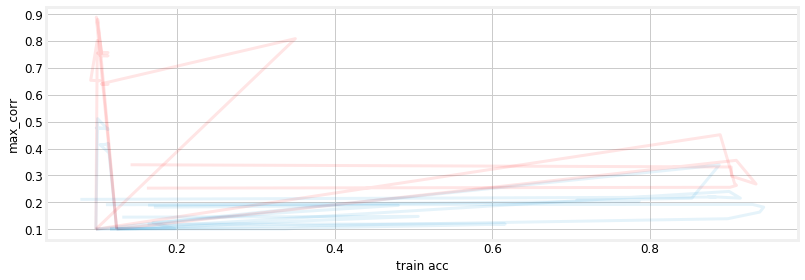

In [31]:
# rm = results[(results.seed == 0) * (results.dset == 'mnist')]
# rm = results[(results.dset == 'mnist') * (results.max_test_acc >= 0.8)]
plt.figure(figsize=(12, 4))
R, C = 1, 1
for _, row in r.iterrows():

    plt.subplot(R, C, 1)
    idxs = [True if v in ts else False for v in row.its[:row.accs_train.size]]
    accs_train = row.accs_train[idxs]
    plt.plot(accs_train, row.corr0, color='red' if row.optimizer=='adam' else cb, alpha=0.1)
#     plt.scatter(accs_train, row.corr0, c=accs_train) #color='red' if row.optimizer=='adam' else cb, alpha=0.1)    
#     plt.plot([accs_train[0], accs_train[1], accs_train[-1]], [row.corr0[0], row.corr0[1], row.corr0[-1]]) #, color='red' if row.optimizer=='adam' else cb, alpha=0.1)    
#     plt.plot([accs_train[3], accs_train[-1]], [row.corr0[3], row.corr0[-1]], alpha=0.5) #, color='red' if row.optimizer=='adam' else cb, alpha=0.1)        
    plt.xlabel('train acc')
    plt.ylabel('max_corr')
    
    '''
    
    plt.plot(row.its[:row.accs_train.size], row.accs_train, 
    plt.xlabel('epochs')
    plt.ylabel('max_corr')
    plt.xlim((0, 20))
    
    plt.subplot(R, C, 2)
    plt.title('max')
    
    plt.plot(ts, row.corr0, color='red' if row.optimizer=='adam' else cb, alpha=0.5)
    plt.xlabel('epochs')
    plt.ylabel('max_corr')
    plt.xlim((0, 20))
    '''
    

In [ ]:
np.unique(results.num_layers)
np.unique(results.optimizer, return_counts=True)

# stability over random init
**note there are some nans/infs here which are being ignored**

In [ ]:
sweep_params = ['lr', 'optimizer', 'num_layers', 'dset', 'batch_size', 'shuffle_labels', 'hidden_size']# wanna group by everything but seed
r = results[results.shuffle_labels == False]
r_mu = r.groupby(sweep_params).mean()
r_std = r.groupby(sweep_params).std()
r_snr = r_mu / r_std
r_mu = r_mu.reset_index()
r_std = r_std.reset_index()
# print(r_mu.describe())

R, C = 2, 5
vals = ['max_train_acc', 'max_test_acc', 'corr0_final', 'corr1_final', 
        'fc0_fro_final', 'fc1_fro_final', 'fc0_stab_rank_final', 'fc1_stab_rank_final', 'act0_stab_rank_final', 'act1_stab_rank_final']
val_labs = ['Train Acc', 'Test Acc', '$\\rho_{mem}(W_1)$', '$\\rho_{mem}(W_2)$', 
        '$||W_1||_F$', '$||W_2||_F$', 'Stable rank($||W_1||$)', 'Stable rank($||W_2||$)', 'Stable rank($||A_1||$)', 'Stable rank($||A_2||$)']

plt.figure(figsize=(20, 9.5))
for i, val in enumerate(vals):
    plt.subplot(R, C, i + 1)
    plt.title(val_labs[i])
#     plt.title(chr(ord('A') + i), loc='left', fontweight='bold')
    sns.scatterplot(r_mu[val], r_std[val], legend=None, alpha=0.5) # hue=r_mu['optimizer'], 

    # print diag line
    left, right = plt.xlim()  # return the current xlim
    xspace = np.linspace(0, right, 100)
    plt.plot(xspace, xspace, '--', alpha=0.5, color='black')
    ymax = np.max(r_std[val])
    dy = ymax / 20
    plt.ylim(-dy, ymax + dy)
    plt.xlabel('Mean')
    plt.ylabel('S.D.')
plt.tight_layout()
plt.savefig('stability_full.pdf')
plt.show()

*bar graphs*

In [ ]:
means = [] 
medians = []
# plt.figure(figsize=(4, 2), dpi=100)
for i, val in enumerate(vals):
    snr = r_snr[val].values
    snr = snr[np.isfinite(snr)]
    means.append(np.mean(snr))
    medians.append(np.median(snr))
# r_snr['max_train_acc']
# sns.barplot(x = means, y = vals, orient='h')

sns.barplot(x = medians, y = val_labs, orient='h', color=cb, alpha=0.5)
plt.xlabel("Median signal to noise ratio\n(Mean / S.D. across random initializations)")
plt.tight_layout()
plt.savefig('stability_bars.pdf')
plt.show()

*snr hists*

In [ ]:
sweep_params = ['lr', 'optimizer', 'num_layers', 'dset', 'batch_size', 'shuffle_labels', 'hidden_size']# wanna group by everything but seed
r = results[results.shuffle_labels == False]
r_mu = r.groupby(sweep_params).mean()
r_std = r.groupby(sweep_params).std()
r_snr = r_mu / r_std
r_mu = r_mu.reset_index()
r_std = r_std.reset_index()
# print(r_mu.describe())

R, C = 4, 4
vals = ['max_train_acc', 'max_test_acc', 'corr0_final', 'corr1_final', 
        'fc0_fro_final', 'fc1_fro_final', 'fc0_stab_rank_final', 'fc1_stab_rank_final', 'act0_stab_rank_final', 'act1_stab_rank_final']
plt.figure(figsize=(12, 18), dpi=100)
for i, val in enumerate(vals):
    plt.subplot(R, C, i + 1)
    plt.title(val)
    snr = r_snr[val].values
    snr = snr[np.isfinite(snr)]
    plt.hist(snr)
plt.show()

# pick individual examples to plot

In [ ]:
r = results
sweep_params = ['lr', 'optimizer', 'num_layers', 'dset', 'batch_size', 'shuffle_labels', 'hidden_size']# wanna group by everything but seed

r = r[(r.dset == 'mnist')] # good mnist
r = r[r.shuffle_labels == False]
r = r[r.max_train_acc >= 0.99]
r = r[r.hidden_size == 512]
# r = r[r.max_train_acc < 0.9]
r = r.groupby(sweep_params)
r = r.filter(lambda x: len(x) > 5) # groups must contain at least 6 runs
r = r.groupby(sweep_params)

In [ ]:
print(r.groups)

In [ ]:
# print(r.groups)
g1 = (0.05, 'sgd', 4, 'mnist', 10, False, 512) #(1, 'sgd', 2, 'mnist', 100, False, 512)
g2 = (0.001, 'adam', 4, 'mnist', 10, False, 512) #(0.001, 'adam', 2, 'mnist', 100, False, 512)
gs = [g1, g2]
labs = ['SGD', 'ADAM']
print(r.get_group(g1).shape, r.get_group(g2).shape)

In [ ]:
# take vector x of length epochs
# np array num_rows x epochs
# errbars with std
def plot_with_std(x, ymat, label=None):
    y = ymat.mean(axis=0)
    yerr = ymat.std(axis=0)
    ymin = y - yerr
    ymax = y + yerr
    plt.plot(x, y, label=label)
    plt.fill_between(x, ymin, ymax, alpha=0.3)

R, C = 2, 5
plt.figure(figsize=(16, 6))
xlim = 100

vals = ['accs_train', 'accs_test', 'corr0', 'corr1', 'fc0_fro', 'fc1_fro', 'fc0_stab_rank', 'fc1_stab_rank', 'act0_stab_rank', 'act1_stab_rank']
val_labs = ['Train Acc', 'Test Acc', '$\\rho_{mem}(W_1)$', '$\\rho_{mem}(W_2)$', 
        '$||W_1||_F$', '$||W_2||_F$', 'Stable rank($||W_1||$)', 'Stable rank($||W_2||$)', 'Stable rank($||A_1||$)', 'Stable rank($||A_2||$)']

for j, g_idx in enumerate([g1, g2]):
    g = r.get_group(g_idx)
    
    for i, val in enumerate(vals):
        ymat = np.array([np.array(x) for x in g[val]])
        
        plt.subplot(R, C, i + 1)
#         plt.title(chr(ord('A') + i), loc='left', fontweight='bold')
        
        if ymat.shape[1] == len(ts):
            x = ts
        else:
            x = its
        plot_with_std(x, ymat, label=labs[j])
        
        plt.xlim((-1, xlim))
        plt.xlabel('Epochs')
        plt.ylabel(val_labs[i])
        if i <= 4: 
            plt.xlabel("")
#         plt.axes().xaxis('off')
            
        if i == 0:
            plt.legend()
plt.tight_layout()
plt.savefig('metrics.pdf')
# plt.subplots_adjust(hspace=0)

# inspect individual vars

In [ ]:
sweep_params = ['lr', 'optimizer', 'num_layers', 'dset', 'batch_size', 'shuffle_labels', 'hidden_size']# wanna group by everything but seed

### plot test acc vs corr0

In [ ]:
r = results
sweep_params = ['lr', 'optimizer', 'num_layers', 'dset', 'batch_size', 'shuffle_labels', 'hidden_size']# wanna group by everything but seed
r = r.groupby(sweep_params).mean().reset_index()
r = r[r.shuffle_labels == False]

hue = 'optimizer'

plt.figure(figsize=(10, 10))
R, C = 2, 2
rm = r[r.dset == 'mnist']
plt.subplot(R, C, 1)
plt.title('mnist')

import matplotlib.patches as mpatches

cs = {'sgd': '008fd5', 'adam': 'fc4f30'}
red_patch = mpatches.Patch(color='red', label='The red data')
plt.legend(handles=[red_patch])


sns.scatterplot(rm.max_test_acc, rm.corr0_final, hue=[cs[key] for key in rm.optimizer])
plt.ylim(0, 1)

plt.subplot(R, C, 2)
plt.title('mnist')
sns.scatterplot(rm.max_test_acc, rm.corr1_final, hue=rm[hue])
plt.ylim(0, 1)


rm = r[r.dset == 'cifar10']
plt.subplot(R, C, 3)
plt.title('cifar')
sns.scatterplot(rm.max_test_acc, rm.corr0_final, hue=rm[hue])
plt.ylim(0, 1)

plt.subplot(R, C, 4)
plt.title('cifar')
sns.scatterplot(rm.max_test_acc, rm.corr1_final, hue=rm[hue])
plt.ylim(0, 1)
plt.show()

### corr0 vs hidden_size

In [ ]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

r = results
r = r[r.shuffle_labels == False]
r = r[r.max_train_acc >= 0.9]
sweep_params = ['lr', 'optimizer', 'num_layers', 'dset', 'batch_size', 'shuffle_labels', 'hidden_size']# wanna group by everything but seed
r = r.groupby(sweep_params).mean().reset_index()


plt.figure(figsize=(10, 10), facecolor='white')
R, C = 2, 2


legend_elements = [Line2D([0], [0], marker='o', linestyle='None', color=cb, lw=4, label='128', alpha=0.5),
                   Line2D([0], [0], marker='o', linestyle='None', color=cr, lw=4, label='512', alpha=0.5)]
cs = {128: cb, 512: cr}
rm = r[r.dset == 'mnist']
plt.subplot(R, C, 1)
plt.title('mnist')
# print(rm.keys())
plt.scatter(rm.max_test_acc, rm.corr0_adj_final, 
            color=[cs[key] for key in rm.hidden_size], alpha=0.5)
plt.legend(handles=legend_elements)
plt.ylim(0, 1)


print(r.groupby('hidden_size').mean())
'''
plt.subplot(R, C, 2)
plt.title('mnist')
sns.scatterplot(rm.max_test_acc, rm.corr1_final, hue=rm[hue])
plt.ylim(0, 1)


rm = r[r.dset == 'cifar10']
plt.subplot(R, C, 3)
plt.title('cifar')
sns.scatterplot(rm.max_test_acc, rm.corr0_final, hue=rm[hue])
plt.ylim(0, 1)

plt.subplot(R, C, 4)
plt.title('cifar')
sns.scatterplot(rm.max_test_acc, rm.corr1_final, hue=rm[hue])
plt.ylim(0, 1)
plt.show()
'''